## Lecture des données

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [54]:
%cd "/content/drive/MyDrive/prediction_classification"

/content/drive/MyDrive/prediction_classification


In [55]:
import pandas as pd


#Chargement du jeu de données
df=pd.read_json("corpus.json", lines=True)

In [56]:
#Nombre d'entrées du jeu de données
len(df)

73

In [57]:
#Prévisualisation des premières entrées (3 premières lignes)

In [58]:
df.sample(2)

,expression,action
19,boolel ma ci,ajouter
20,boolel ma,ajouter


In [59]:
# Type des différentes colonnes

In [60]:
df.dtypes

expression    object
action        object
dtype: object

## Distribution des catégories

### Nombre d'action du jeu de données

In [61]:
len(set(df['action'].values))

9

### Nombre d'entrées par catégorie

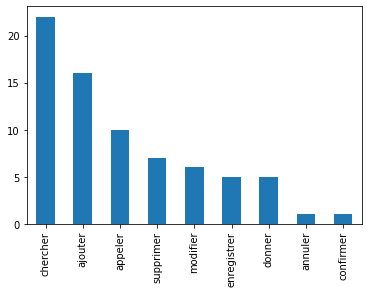

In [62]:
df['action'].value_counts().plot(kind='bar')

## Classification des textes

In [63]:
import re

#just the expression
df['expression']=df['expression']

# #description + keyword
df['expression_action'] = df['action'] + ' '+ df['expression']

# #description + keyword + consignee
df['expression_action_repeat'] = df['action'] + ' '+ df['expression']+" " + df['expression']


In [64]:
df=df.rename(columns={'action': 'category'})

In [65]:
df.sample(2)

,expression,category,expression_action,expression_action_repeat
63,dolilmaci,ajouter,ajouter dolilmaci,ajouter dolilmaci dolilmaci
51,ubbilma,chercher,chercher ubbilma,chercher ubbilma ubbilma


### Diviser l'ensemble de données pour l'entrainement et le test


In [66]:
### methode pour l'extraction des caractéristiques

from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

import numpy as np
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

def extract_features(df,field,training_data,testing_data,type="binary"):
    """Extract features using different methods"""
    
    logging.info("Extracting features and creating vocabulary...")
    
    if "binary" in type:
        
        # BINARY FEATURE REPRESENTATION
        cv= CountVectorizer(binary=True, max_df=0.95)
        cv.fit_transform(training_data[field].values)
        
        train_feature_set=cv.transform(training_data[field].values)
        test_feature_set=cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
  
    elif "counts" in type:
        
        # COUNT BASED FEATURE REPRESENTATION
        cv= CountVectorizer(binary=False, max_df=0.95)
        cv.fit_transform(training_data[field].values)
        
        train_feature_set=cv.transform(training_data[field].values)
        test_feature_set=cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
    
    else:    
        
        # TF-IDF BASED FEATURE REPRESENTATION
        tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
        tfidf_vectorizer.fit_transform(training_data[field].values)
        
        train_feature_set=tfidf_vectorizer.transform(training_data[field].values)
        test_feature_set=tfidf_vectorizer.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,tfidf_vectorizer

In [67]:

def _reciprocal_rank(true_labels: list, machine_preds: list):
    """Compute the reciprocal rank at cutoff k"""
    
    # add index to list only if machine predicted label exists in true labels
    tp_pos_list = [(idx + 1) for idx, r in enumerate(machine_preds) if r in true_labels]

    rr = 0
    if len(tp_pos_list) > 0:
        # for RR we need position of first correct item
        first_pos_list = tp_pos_list[0]
        
        # rr = 1/rank
        rr = 1 / float(first_pos_list)

    return rr

def compute_mrr_at_k(items:list):
    """Compute the MRR (average RR) at cutoff k"""
    rr_total = 0  
    for item in items:   
        rr_at_k = _reciprocal_rank(item[0],item[1])
        rr_total = rr_total + rr_at_k
        mrr = rr_total / 1/float(len(items))
    return mrr

def collect_preds(Y_test,Y_preds):
    """Collect all predictions and ground truth"""
    
    pred_gold_list=[[[Y_test[idx]],pred] for idx,pred in enumerate(Y_preds)]
    return pred_gold_list
             
def compute_accuracy(eval_items:list):
    correct=0
    total=0
    
    for item in eval_items:
        true_pred=item[0]
        machine_pred=set(item[1])
        
        for cat in true_pred:
            if cat in machine_pred:
                correct+=1
                break

def get_top_k_predictions(model,X_test,k):
    
    # get probabilities instead of predicted labels, since we want to collect top 3
    probs = model.predict_proba(X_test)

    # GET TOP K PREDICTIONS BY PROB - note these are just index
    best_n = np.argsort(probs, axis=1)[:,-k:]
    
    # GET CATEGORY OF PREDICTIONS
    preds=[[model.classes_[predicted_cat] for predicted_cat in prediction] for prediction in best_n]
    
    preds=[ item[::-1] for item in preds]
    
    return preds
   



In [68]:


def train_model(df,field="text_desc",feature_rep="binary",top_k=3):
    
    logging.info("Starting model training...")
    
    # GET A TRAIN TEST SPLIT (set seed for consistent results)
    training_data, testing_data = train_test_split(df,random_state = 73,)

    # GET LABELS
    Y_train=training_data['category'].values
    Y_test=testing_data['category'].values
     
    # GET FEATURES
    X_train,X_test,feature_transformer=extract_features(df,field,training_data,testing_data,type=feature_rep)

    # INIT LOGISTIC REGRESSION CLASSIFIER
    logging.info("Training a Logistic Regression Model...")
    scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=73)
    model=scikit_log_reg.fit(X_train,Y_train)

    # GET TOP K PREDICTIONS
    preds=get_top_k_predictions(model,X_test,top_k)
    
    # GET PREDICTED VALUES AND GROUND TRUTH INTO A LIST OF LISTS - for ease of evaluation
    eval_items=collect_preds(Y_test,preds)
    
    # GET EVALUATION NUMBERS ON TEST SET -- HOW DID WE DO?
    logging.info("Starting evaluation...")
    accuracy=compute_accuracy(eval_items)
    mrr_at_k=compute_mrr_at_k(eval_items)
    
    logging.info("Done training and evaluation.")
    
    return model,feature_transformer,accuracy,mrr_at_k


### Model - 1 (tfidf features with description only)

In [69]:
field='expression'
feature_rep='binary'
top_k=1

model,transformer,accuracy,mrr_at_k = train_model(df,field=field,feature_rep=feature_rep,top_k=top_k)
print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

2022-03-04 17:05:32,031 : INFO : Starting model training...
2022-03-04 17:05:32,040 : INFO : Extracting features and creating vocabulary...
2022-03-04 17:05:32,046 : INFO : Training a Logistic Regression Model...
2022-03-04 17:05:32,056 : INFO : Starting evaluation...
2022-03-04 17:05:32,062 : INFO : Done training and evaluation.


[LibLinear]
Accuracy=None; MRR=0.5789473684210527


### Model - 2 (tfidf features with description and keyword)

In [70]:
field='expression_action'
feature_rep='tfidf'
top_k=3

model,transformer,accuracy,mrr_at_k = train_model(df,field=field,feature_rep=feature_rep,top_k=top_k)
print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

2022-03-04 17:05:32,081 : INFO : Starting model training...
2022-03-04 17:05:32,091 : INFO : Extracting features and creating vocabulary...
2022-03-04 17:05:32,103 : INFO : Training a Logistic Regression Model...
2022-03-04 17:05:32,111 : INFO : Starting evaluation...
2022-03-04 17:05:32,115 : INFO : Done training and evaluation.


[LibLinear]
Accuracy=None; MRR=0.9473684210526315


### Model - 3 (tfidf features with description, keywords, consignee)

In [71]:
field='expression_action_repeat'
feature_rep='tfidf'
top_k=3

model,transformer,accuracy,mrr_at_k = train_model(df,field=field,feature_rep=feature_rep,top_k=top_k)
print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

2022-03-04 17:05:32,129 : INFO : Starting model training...
2022-03-04 17:05:32,135 : INFO : Extracting features and creating vocabulary...
2022-03-04 17:05:32,150 : INFO : Training a Logistic Regression Model...
2022-03-04 17:05:32,159 : INFO : Starting evaluation...
2022-03-04 17:05:32,163 : INFO : Done training and evaluation.


[LibLinear]
Accuracy=None; MRR=0.9473684210526315


## Vérification des prévisions

In [72]:
test_features=transformer.transform(["Diokhma"])
get_top_k_predictions(model,test_features,2)

[['chercher', 'ajouter']]

In [73]:
test_features=transformer.transform(["dindil ma"])
model.predict(test_features)
get_top_k_predictions(model,test_features,2)

[['supprimer', 'chercher']]

In [74]:
test_features=transformer.transform(["soppil ma"])
get_top_k_predictions(model,test_features,2)

[['modifier', 'chercher']]

## Entrainement différents types de modèles

In [75]:
feature_reps=['binary','counts','tfidf']
fields=['expression','expression_action','expression_action_repeat']
top_ks=[3]

results=[]
for field in fields:
    for feature_rep in feature_reps:
        for top_k in top_ks:
            model,transformer,acc,mrr_at_k = train_model(df,field=field,feature_rep=feature_rep,top_k=top_k)
            results.append([field,feature_rep,top_k,acc,mrr_at_k])

2022-03-04 17:05:32,228 : INFO : Starting model training...
2022-03-04 17:05:32,234 : INFO : Extracting features and creating vocabulary...
2022-03-04 17:05:32,240 : INFO : Training a Logistic Regression Model...
2022-03-04 17:05:32,250 : INFO : Starting evaluation...


[LibLinear]

2022-03-04 17:05:32,256 : INFO : Done training and evaluation.
2022-03-04 17:05:32,258 : INFO : Starting model training...
2022-03-04 17:05:32,261 : INFO : Extracting features and creating vocabulary...
2022-03-04 17:05:32,267 : INFO : Training a Logistic Regression Model...
2022-03-04 17:05:32,276 : INFO : Starting evaluation...
2022-03-04 17:05:32,278 : INFO : Done training and evaluation.
2022-03-04 17:05:32,280 : INFO : Starting model training...
2022-03-04 17:05:32,283 : INFO : Extracting features and creating vocabulary...
2022-03-04 17:05:32,292 : INFO : Training a Logistic Regression Model...
2022-03-04 17:05:32,304 : INFO : Starting evaluation...
2022-03-04 17:05:32,306 : INFO : Done training and evaluation.


[LibLinear][LibLinear]

2022-03-04 17:05:32,308 : INFO : Starting model training...
2022-03-04 17:05:32,312 : INFO : Extracting features and creating vocabulary...
2022-03-04 17:05:32,317 : INFO : Training a Logistic Regression Model...
2022-03-04 17:05:32,322 : INFO : Starting evaluation...
2022-03-04 17:05:32,329 : INFO : Done training and evaluation.
2022-03-04 17:05:32,331 : INFO : Starting model training...
2022-03-04 17:05:32,334 : INFO : Extracting features and creating vocabulary...
2022-03-04 17:05:32,338 : INFO : Training a Logistic Regression Model...
2022-03-04 17:05:32,344 : INFO : Starting evaluation...
2022-03-04 17:05:32,346 : INFO : Done training and evaluation.
2022-03-04 17:05:32,347 : INFO : Starting model training...
2022-03-04 17:05:32,351 : INFO : Extracting features and creating vocabulary...


[LibLinear][LibLinear]

2022-03-04 17:05:32,361 : INFO : Training a Logistic Regression Model...
2022-03-04 17:05:32,379 : INFO : Starting evaluation...
2022-03-04 17:05:32,381 : INFO : Done training and evaluation.
2022-03-04 17:05:32,384 : INFO : Starting model training...
2022-03-04 17:05:32,387 : INFO : Extracting features and creating vocabulary...
2022-03-04 17:05:32,392 : INFO : Training a Logistic Regression Model...
2022-03-04 17:05:32,406 : INFO : Starting evaluation...
2022-03-04 17:05:32,410 : INFO : Done training and evaluation.
2022-03-04 17:05:32,413 : INFO : Starting model training...
2022-03-04 17:05:32,418 : INFO : Extracting features and creating vocabulary...
2022-03-04 17:05:32,428 : INFO : Training a Logistic Regression Model...
2022-03-04 17:05:32,433 : INFO : Starting evaluation...
2022-03-04 17:05:32,435 : INFO : Done training and evaluation.
2022-03-04 17:05:32,437 : INFO : Starting model training...
2022-03-04 17:05:32,445 : INFO : Extracting features and creating vocabulary...


[LibLinear][LibLinear][LibLinear]

2022-03-04 17:05:32,464 : INFO : Training a Logistic Regression Model...
2022-03-04 17:05:32,475 : INFO : Starting evaluation...


[LibLinear]

2022-03-04 17:05:32,479 : INFO : Done training and evaluation.


### Résultats des divers modèles

In [76]:
df_results=pd.DataFrame(results,columns=['text_fields','feature_representation','top_k','accuracy','mrr_at_k'])
df_results.sort_values(by=['text_fields','accuracy'],ascending=False)

,text_fields,feature_representation,top_k,accuracy,mrr_at_k
6,expression_action_repeat,binary,3,None,0.947368
7,expression_action_repeat,counts,3,None,0.947368
8,expression_action_repeat,tfidf,3,None,0.947368
3,expression_action,binary,3,None,0.947368
4,expression_action,counts,3,None,0.947368
5,expression_action,tfidf,3,None,0.947368
0,expression,binary,3,None,0.675439
1,expression,counts,3,None,0.675439
2,expression,tfidf,3,None,0.701754


## Enregistrement du modèle pour une utilisation future


In [77]:
import pickle

model_path="./models/model.pkl"
transformer_path="./models/transformer.pkl"

# we need to save both the transformer -> to encode a document and the model itself to make predictions based on the weight vectors 
pickle.dump(model,open(model_path, 'wb'))
pickle.dump(transformer,open(transformer_path,'wb'))


In [88]:

loaded_model = pickle.load(open(model_path, 'rb'))
loaded_transformer = pickle.load(open(transformer_path, 'rb'))
test_features=loaded_transformer.transform(["boolelma ci"])
get_top_k_predictions(loaded_model,test_features,1)

[['ajouter']]